In [2]:
from pathlib import Path

import math
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import datetime as dt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import os


from dmba import regressionSummary, classificationSummary
from dmba import liftChart, gainsChart
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from IPython.display import Image  
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.tree import export_graphviz
from six import StringIO 
import pydotplus
import graphviz
from sklearn import metrics


In [37]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [6]:
!pip install graphviz
!pip install pydotplus

In [16]:
train_df = pd.read_csv('FlightDelays.csv')
train_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,37987,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime


In [4]:
train_df.to_csv('FlightDelaysTrainingData.csv',index= False)
train_df.to_csv('FlightDelaysExploration.csv',index= False)

In [5]:
columns = ['CRS_DEP_TIME', 'DEP_TIME','DAY_WEEK', 'DISTANCE','Weather']


df_Predictors = pd.get_dummies(train_df[columns], drop_first=True)

In [6]:
df_Predictors.head()
df_Predictors.shape

(2201, 5)

In [7]:
norm_df = (df_Predictors - df_Predictors.mean()) / df_Predictors.std()
print(norm_df)

      CRS_DEP_TIME  DEP_TIME  DAY_WEEK  DISTANCE   Weather
0         0.191962  0.193691  0.049656 -2.092950 -0.121436
1         0.619513  0.611805  0.049656  0.084748 -0.121436
2        -0.293366 -0.280925  0.049656  1.286237 -0.121436
3         0.792844  0.767751  0.049656  1.286237 -0.121436
4        -0.769450 -0.755541  0.049656  1.286237 -0.121436
...            ...       ...       ...       ...       ...
2196     -1.680017 -1.639232  1.100546 -0.966554 -0.121436
2197      0.758178  0.641186  1.100546  0.084748 -0.121436
2198      0.527069  0.426479  1.100546 -0.966554 -0.121436
2199     -0.029902  0.076167  1.100546 -0.966554 -0.121436
2200      0.827510  0.828773  1.100546 -0.966554 -0.121436

[2201 rows x 5 columns]


<AxesSubplot:>

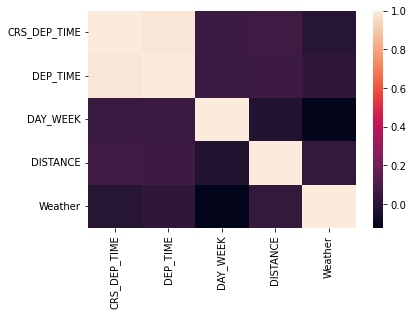

In [8]:
corr = norm_df.corr()
sns.heatmap(corr)

<AxesSubplot:>

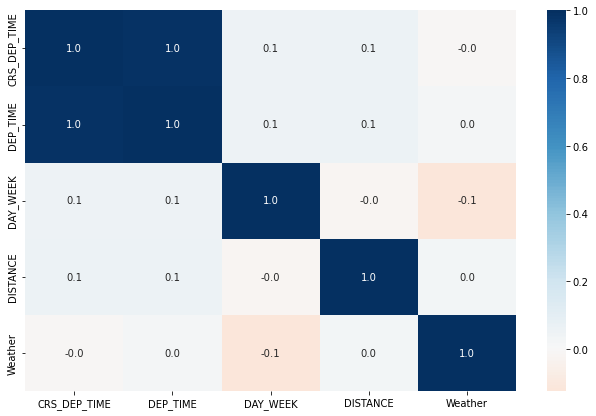

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

In [10]:
data_exploration = pd.read_csv('FlightDelaysExploration.csv')
data_exploration.describe()

,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,1371.938664,1369.298955,211.871422,3815.086324,0.014539,3.905498,16.024989
std,432.697149,442.462754,13.316815,2409.750224,0.119725,1.903149,8.677390
min,600.000000,10.000000,169.000000,746.000000,0.000000,1.000000,1.000000
25%,1000.000000,1004.000000,213.000000,2156.000000,0.000000,2.000000,8.000000
50%,1455.000000,1450.000000,214.000000,2385.000000,0.000000,4.000000,16.000000
75%,1710.000000,1709.000000,214.000000,6155.000000,0.000000,5.000000,23.000000
max,2130.000000,2330.000000,229.000000,7924.000000,1.000000,7.000000,31.000000


In [11]:
day = []
for row in data_exploration['DAY_WEEK']:
        if row == 1 :    day.append('Monday')
        elif row == 2:   day.append('Tuesday')
        elif row == 3:   day.append('Wednesday')
        elif row == 4:   day.append('Thursday')
        elif row == 5:   day.append('Friday')
        elif row == 6:   day.append('Saturday')
        else :           day.append('Sunday')
data_exploration['day']=day
data_exploration
pv1=data_exploration.groupby(['day'])['Flight Status'].value_counts()
pv1

day        Flight Status
Friday     ontime           316
           delayed           75
Monday     ontime           224
           delayed           84
Saturday   ontime           226
           delayed           24
Sunday     ontime           185
           delayed           68
Thursday   ontime           315
           delayed           57
Tuesday    ontime           244
           delayed           63
Wednesday  ontime           263
           delayed           57
Name: Flight Status, dtype: int64

In [19]:
stats = pd.pivot_table(train_df, values='DISTANCE', index=['ORIGIN','DEST'],
                    columns=['CARRIER'], aggfunc=np.mean, fill_value=0)

print(stats)

CARRIER       CO   DH   DL   MQ   OH   RU   UA   US
ORIGIN DEST                                        
BWI    EWR     0    0    0    0    0  169    0    0
       JFK     0    0    0    0  184    0    0    0
DCA    EWR   199    0    0    0    0  199    0    0
       JFK     0  213  213  213    0    0    0    0
       LGA     0    0  214  214    0    0    0  214
IAD    EWR     0  213    0    0    0  213    0    0
       JFK     0  228    0    0    0    0    0    0
       LGA     0  229    0    0    0    0  229    0


In [21]:
dest=data_exploration.CARRIER.value_counts()
print(dest)

DH    551
RU    408
US    404
DL    388
MQ    295
CO     94
UA     31
OH     30
Name: CARRIER, dtype: int64


<BarContainer object of 3 artists>

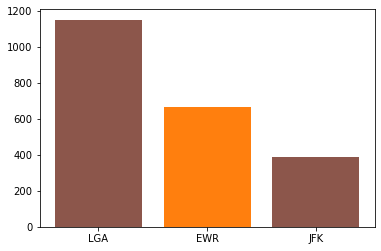

In [12]:
dest=data_exploration.DEST.value_counts()
fig,ax = plt.subplots()
ax.bar(dest.index, dest, color=['C5', 'C1'])

<BarContainer object of 3 artists>

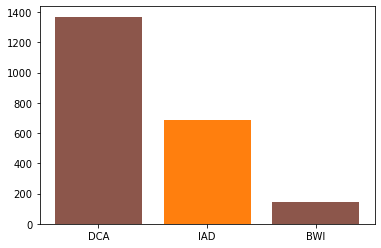

In [13]:
org = data_exploration.ORIGIN.value_counts()
fig,ax = plt.subplots()
ax.bar(org.index, org, color=['C5', 'C1'])

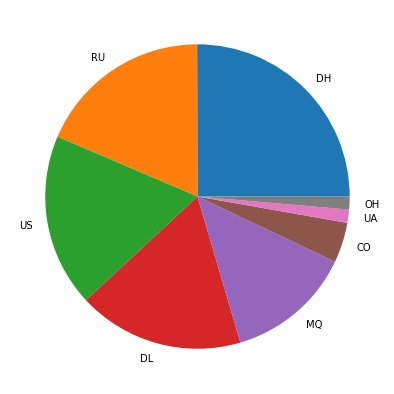

DH    551
RU    408
US    404
DL    388
MQ    295
CO     94
UA     31
OH     30
Name: CARRIER, dtype: int64

In [24]:
Car=data_exploration.CARRIER.value_counts()
labels = ['DH','RU','US','DL','MQ','CO','UA','OH']
fig = plt.figure(figsize =(10, 7))
plt.pie(Car, labels = labels)
plt.show()
Car

In [25]:
train_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,37987,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime


In [26]:

x = pd.get_dummies(train_df[['CRS_DEP_TIME', 'CARRIER','DEP_TIME','DEST','DAY_WEEK', 'DISTANCE','FL_NUM','ORIGIN','Weather']])
y = train_df['Flight Status']

y
x.shape

(2201, 20)

In [27]:
tra_x,tes_x,tra_y,tes_y = train_test_split(x,y, test_size=0.4, random_state=1)


In [28]:

for col in tra_x.columns:
    print(col)

CRS_DEP_TIME
DEP_TIME
DAY_WEEK
DISTANCE
FL_NUM
Weather
CARRIER_CO
CARRIER_DH
CARRIER_DL
CARRIER_MQ
CARRIER_OH
CARRIER_RU
CARRIER_UA
CARRIER_US
DEST_EWR
DEST_JFK
DEST_LGA
ORIGIN_BWI
ORIGIN_DCA
ORIGIN_IAD


In [29]:
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(tra_x, tra_y)

MultinomialNB(alpha=0.01)

In [30]:
predProb_train = delays_nb.predict_proba(train_x)

predProb_valid = delays_nb.predict_proba(test_x)
predProb_valid

NameError: name 'train_x' is not defined

In [31]:
y_valid_pred = delays_nb.predict(test_x)
y_train_pred = delays_nb.predict(train_x)

NameError: name 'test_x' is not defined

In [32]:
tes = pd.read_csv('test5 .csv')

tes_X = pd.get_dummies(tes[predictors])
tes_y= tes['Flight Status']

print(tes_X)

FileNotFoundError: [Errno 2] No such file or directory: 'test5 .csv'

In [22]:
coloumn_names =['CRS_DEP_TIME','DEP_TIME','DAY_WEEK','DISTANCE','FL_NUM','Weather','CARRIER_CO','CARRIER_DH','CARRIER_DL','CARRIER_MQ','CARRIER_OH','CARRIER_RU','CARRIER_UA','CARRIER_US','DEST_EWR','DEST_JFK','DEST_LGA','ORIGIN_BWI','ORIGIN_DCA','ORIGIN_IAD']

tes_X = tes_X.reindex(columns = coloumn_names)  
test_five=tes_X.fillna(0)

print(a)
a.shape

NameError: name 'tes_X' is not defined

In [23]:
test_pred = delays_nb.predict(a)
test_pred

NameError: name 'delays_nb' is not defined

In [224]:
print("Accuracy:",metrics.accuracy_score(test_y, y_valid_pred))

Accuracy: 0.5686719636776391


In [225]:
clf = DecisionTreeClassifier()

In [226]:
clf = clf.fit(train_x,train_y)

In [227]:
plotDecisionTree(clf, feature_names=train_x.columns, class_names=clf.classes_)

InvocationException: GraphViz's executables not found

In [228]:
y_pred = clf.predict(test_x)

In [229]:
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.8501702610669694


In [232]:
test_five

,CRS_DEP_TIME,DEP_TIME,DAY_WEEK,DISTANCE,FL_NUM,Weather,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD
0,16,0.0,1,228,7810,0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0,1
1,6,0.0,3,214,1740,0,0.0,0,1,0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,1,0
2,6,0.0,2,213,4760,0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,1,0,0.0,1,0
3,18,0.0,3,214,1764,0,0.0,0,1,0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,1,0


In [234]:
y_pred2 = clf.predict(test_five)

In [235]:
y_pred2

array(['delayed', 'ontime', 'ontime', 'ontime'], dtype=object)

In [236]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_x, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [237]:
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.8501702610669694
